# Problem Set 6: Particle Tracking
---
## Setup

In [1]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

In [2]:
# Imports
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
# Matplotlib params
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['lines.markersize'] = 1
# Play video file while tracking
DISPLAY_VIDEO = True

---
## 1. Particle Filter Tracking

In [3]:
# Template position
with open('pres_debate.txt', 'r') as f:
    x0, y0, w0, h0 = [int(float(n)) for n in f.readline().split()]
# Video file
videofile = 'pres_debate.avi'

In [4]:
def get_frame(videofile, n):
    '''
    Get the nth frame from the video.
    '''
    cap = cv2.VideoCapture(videofile)
    for _ in range(n):
        ret, frame = cap.read()
        if ret == True:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float) / 255
        else:
            break
    cap.release()
    return gray

In [5]:
# Extract template
firstframe = get_frame(videofile, 1)
h, w = firstframe.shape
face = firstframe[y0:y0+h0, x0:x0+w0]

In [6]:
class ParticleFilter:
    # ref: https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb
    def __init__(self, template, h, w, include_scale=False, N=100, sigma_error=0.04, sigma_dynamics=10, sigma_scale=0.2, alpha=None, random_ratio=0.0):
        '''
        Create random particles.
        '''
        self.template = template
        self.h, self.w = h, w
        self.include_scale = include_scale
        self.N = N
        self.sigma_dynamics = sigma_dynamics
        self.sigma_error = sigma_error
        self.sigma_scale = sigma_scale
        self.alpha = alpha
        self.random_ratio = random_ratio
        self.ht, self.wt = template.shape[:2]
        self.weights = np.full(N, 1/N)
        if self.include_scale:
            self.particles = np.zeros((N, 3))
            self.particles[:, 2] = np.random.uniform(0.2, 1.0, N)
        else:
            self.particles = np.zeros((N, 2))
        self.particles[:, 0] = np.random.uniform(0, w, N)
        self.particles[:, 1] = np.random.uniform(0, h, N)
        return
    
    def predict(self):
        '''
        Predict next state of set of particles.
        '''
        noise = np.random.normal(0, self.sigma_dynamics, (self.N, 2))
        self.particles[:, :2] += noise
        self.particles[:,0] = np.clip(self.particles[:, 0], 0, self.w - 1)
        self.particles[:,1] = np.clip(self.particles[:, 1], 0, self.h - 1)
        if self.include_scale:
            noise = np.random.normal(0, self.sigma_scale, self.N)
            self.particles[:, 2] += noise
            self.particles[:,2] = np.clip(self.particles[:, 2], 0.2, 1.0)
        return

    def update(self, frame):
        '''
        Update weights of set of particles.
        '''
        weights = np.zeros(self.N)        
        for ix in range(self.N):
            x, y = self.particles[ix, :2]
            template_scaled = self.template
            if self.include_scale:
                scale = self.particles[ix, 2]
                template_scaled = cv2.resize(self.template, None, fx=scale, fy=scale)
            ht, wt = template_scaled.shape[:2]
            x1 = int(x - wt//2)
            x2 = x1 + wt
            y1 = int(y - ht//2)
            y2 = y1 + ht
            state = frame[y1:y2, x1:x2]
            if state.shape == template_scaled.shape:
                mse = np.mean((template_scaled - state)**2)
                p = np.exp(-mse/(2*self.sigma_error**2))
            else:
                p = 0.0
            weights[ix] = p
        weights /= np.sum(weights)
        self.weights = weights
        return

    def resample(self):
        '''
        Resample set based on weights.
        '''
        indices = np.random.choice(self.N, size=self.N, p=self.weights)
        self.particles = self.particles[indices]        
        # Add some random particles
        rand_cnt = int(self.random_ratio*self.N)
        if rand_cnt > 0:
            self.particles[-rand_cnt:, 0] = np.random.uniform(0, self.w, rand_cnt)
            self.particles[-rand_cnt:, 1] = np.random.uniform(0, self.h, rand_cnt)
            if self.include_scale:
                self.particles[-rand_cnt:, 2] = np.random.uniform(0.4, 1.0, rand_cnt)
        return

    def estimate(self):
        '''
        Get state estimate as weighted mean of particles
        '''
        avg =  np.average(self.particles, weights=self.weights, axis=0)
        self.avg_position = avg[:2]
        if self.include_scale:
            self.avg_scale = avg[2]
        diff = self.particles[:, :2] - self.avg_position
        distances = np.sqrt(diff[:, 0]**2 + diff[:, 1]**2)
        self.spread = np.average(distances, weights=self.weights)
        return
    
    def update_template(self, frame):
        '''
        Update template using the current mean window. 
        '''
        x, y = self.avg_position.astype(int)
        # Bounding box centres
        x1 = x - self.wt//2
        y1 = y - self.ht//2
        state = frame[y1:y1+self.ht, x1:x1+self.wt]
        self.template = self.alpha*state + (1-self.alpha)*self.template
        return
    
    def step(self, frame):
        '''
        Perform a single iteration of the particle filter. 
        '''
        self.predict()
        self.update(frame)
        self.estimate()
        self.resample()
        if not self.include_scale and self.alpha:
            self.update_template(frame)
        return

    def plot_particles(self, ax, colour='r'):
        '''
        Get state estimate as weighted mean of particles
        '''
        ax.scatter(self.particles[:, 0], self.particles[:, 1], color=colour)
        return
    
    def plot_window(self, ax, colour='lime'):
        '''
        Plot the bounding box associated with a state.
        '''
        x, y = self.avg_position.astype(int)
        template_scaled = self.template
        if self.include_scale:
            scale = self.avg_scale
            template_scaled = cv2.resize(self.template, None, fx=scale, fy=scale)
        ht, wt = template_scaled.shape[:2]
        # Bounding box centres
        x1 = x - wt//2
        y1 = y - ht//2
        # Rectangle patch
        rect = patches.Rectangle((x1, y1), wt, ht, linewidth=2, edgecolor=colour, facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        return
        
    def plot_spread(self, ax, colour='w'):
        '''
        Plot a circle whose radius is the weighted sum of distances of particles to the mean.
        This is a crude estimate of the standard deviation of the particles.
        '''
        x, y = self.avg_position
        circ = patches.Circle((x, y), radius=self.spread, linewidth=2, edgecolor=colour, facecolor='none')
        ax.add_patch(circ)
        return
    
    def plot_template(self, ax, colour='lime'):
        '''
        Plot the template with a border.
        '''
        ax.imshow(self.template)
        rect = patches.Rectangle((0, 0), self.wt, self.ht, linewidth=2, edgecolor=colour, facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        return
    
    def plot(self, ax, frame):
        '''
        Plot particles and state estimate.
        '''
        ax.imshow(frame)
        self.plot_template(ax)
        self.plot_particles(ax)
        self.plot_window(ax)
        self.plot_spread(ax)
        return
    
    def draw_opencv(self, frame, window_name=''):
        '''
        Draw particles and state estimate using OpenCV functions.
        '''
        frame[:self.ht, :self.wt] = 255*self.template[:, :, np.newaxis]
        cv2.rectangle(frame, (0, 0), (self.wt, self.ht), (0,255,0), 2)
        for p in self.particles:
            x, y = p[:2].astype(int)
            cv2.circle(frame, (x, y), 2, (0,0,255), -1)
        # Scaling
        x, y = self.avg_position.astype(int)
        template_scaled = self.template
        if self.include_scale:
            scale = self.avg_scale
            template_scaled = cv2.resize(self.template, None, fx=scale, fy=scale)
        ht, wt = template_scaled.shape[:2]
        # Bounding box centres
        x1 = x - wt//2
        y1 = y - ht//2
        # Draw rectangle
        cv2.rectangle(frame, (x1, y1), (x1+wt, y1+ht), (0,255,0), 2)
        
        cv2.circle(frame, (x, y), int(self.spread), (255,255,255), 2)
        cv2.imshow(window_name, frame)
        return
    
    def __call__(self, videofile, frames=[], display_video=False):
        '''
        Run the PF on the input video file and track the template.
        '''
        ix = 1
        cap = cv2.VideoCapture(videofile)
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            framegr = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float) / 255

            self.step(framegr)

            if ix in frames:
                fig, ax = plt.subplots(1, 1)
                ax.set_title('Frame {}'.format(ix))
                ax.axis('off')
                self.plot(ax, frame[:, :, ::-1])
            if display_video:
                self.draw_opencv(frame, window_name=videofile)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            ix += 1
        cv2.destroyAllWindows()
        cap.release()
        return

### 1.1 Tracking the face

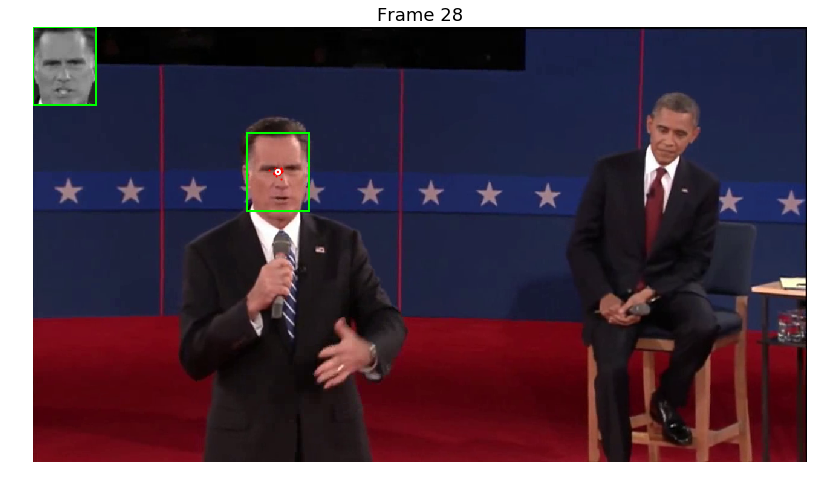

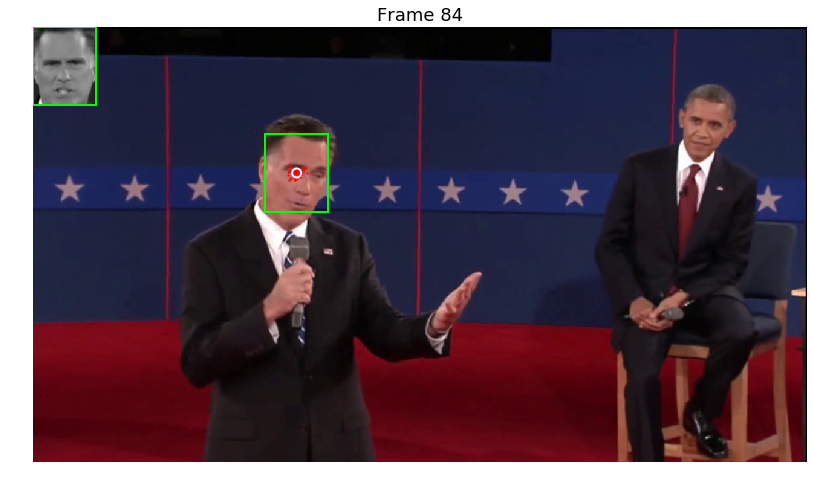

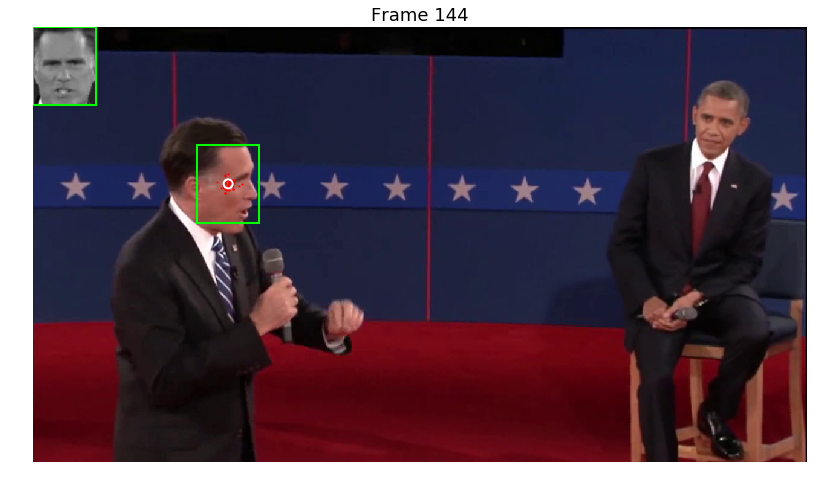

In [278]:
frames = [28, 84, 144]
face_tracker = ParticleFilter(face, h, w, N=100)
face_tracker(videofile, frames=frames, display_video=DISPLAY_VIDEO)

### 1.2

### 1.3

### 1.4

### 1.5 Noisy Clip

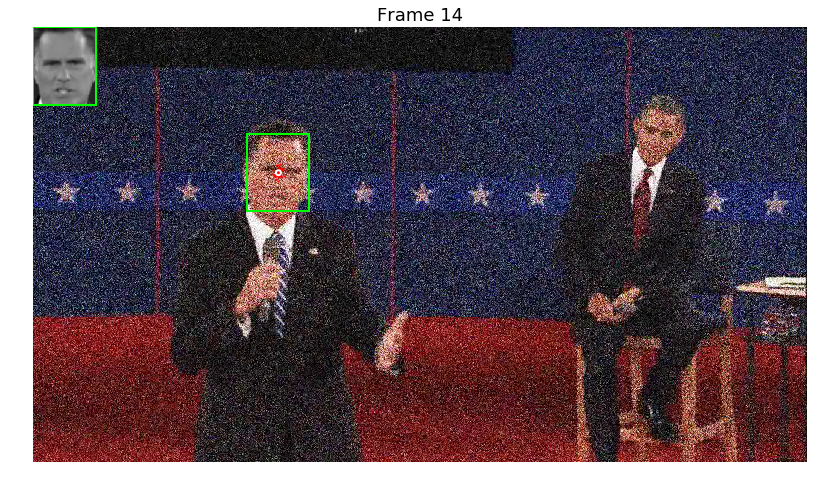

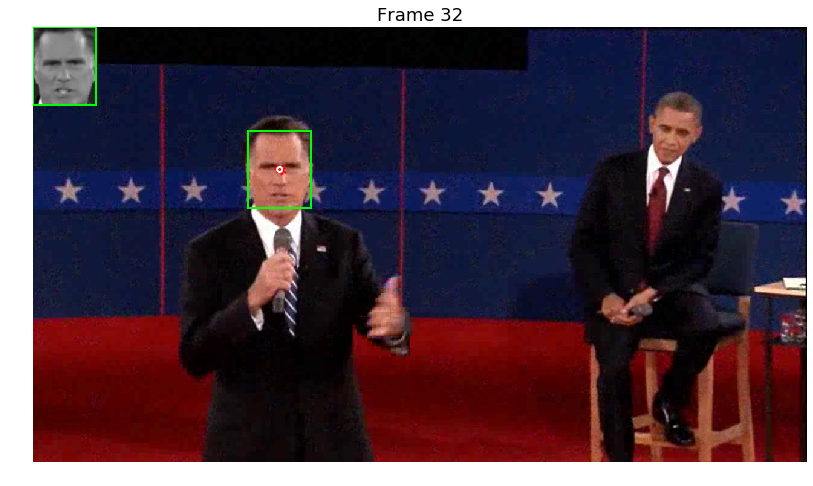

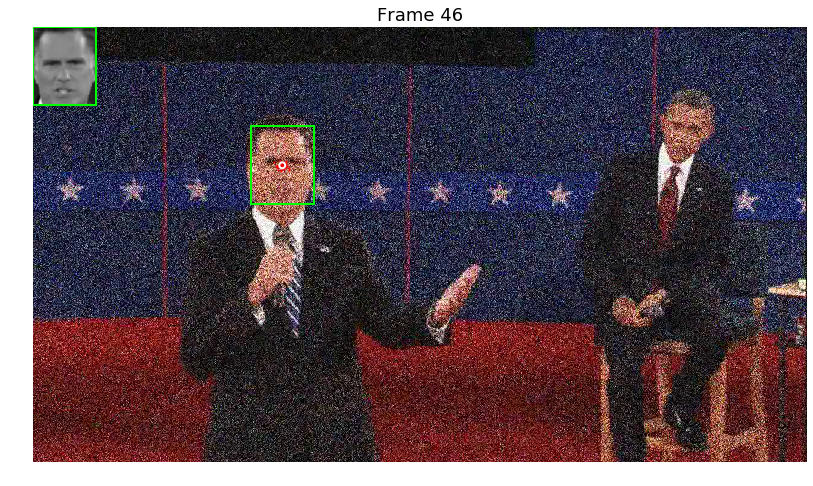

In [279]:
noisyvideo = 'noisy_debate.avi'
frames = [14, 32, 46]
face_tracker = ParticleFilter(face, h, w, N=100)
face_tracker(noisyvideo, frames=frames, display_video=DISPLAY_VIDEO)

---
## 2. Appearance Model Update

In [280]:
# Template position
x0, y0, w0, h0 = 520, 375, 105, 129
# Extract template
hand = firstframe[y0:y0+h0, x0:x0+w0]

### 2.1 Tracking the hand

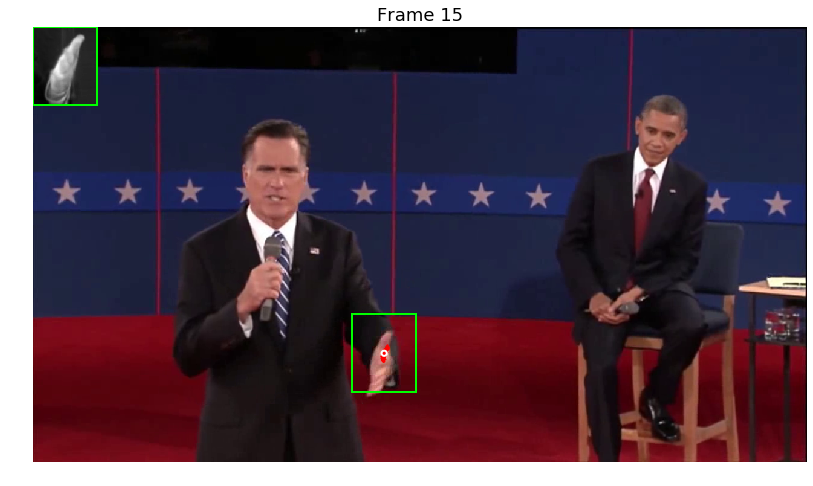

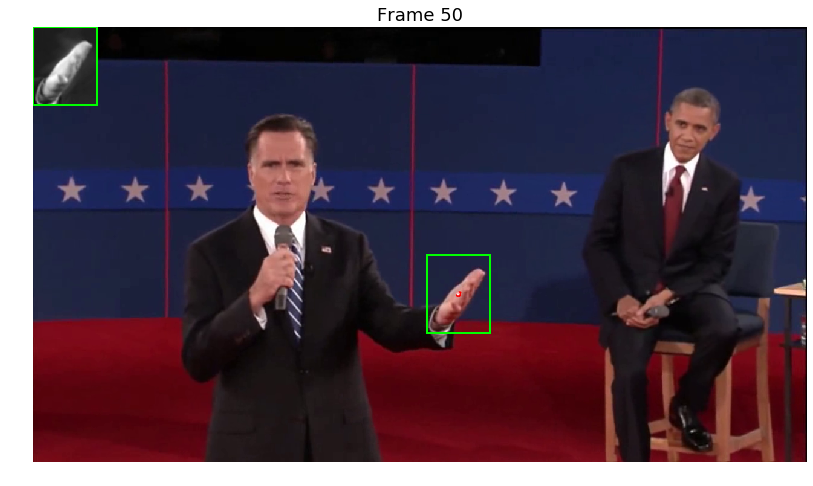

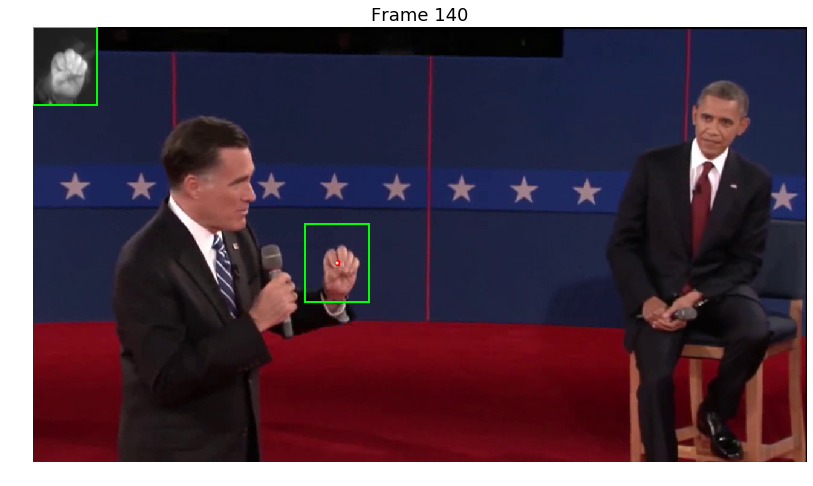

In [281]:
frames = [15, 50, 140]
hand_tracker = ParticleFilter(hand, h, w, N=1000, sigma_error=0.01, alpha=0.1)
hand_tracker(videofile, frames=frames, display_video=DISPLAY_VIDEO)

### 2.2 Noisy Clip

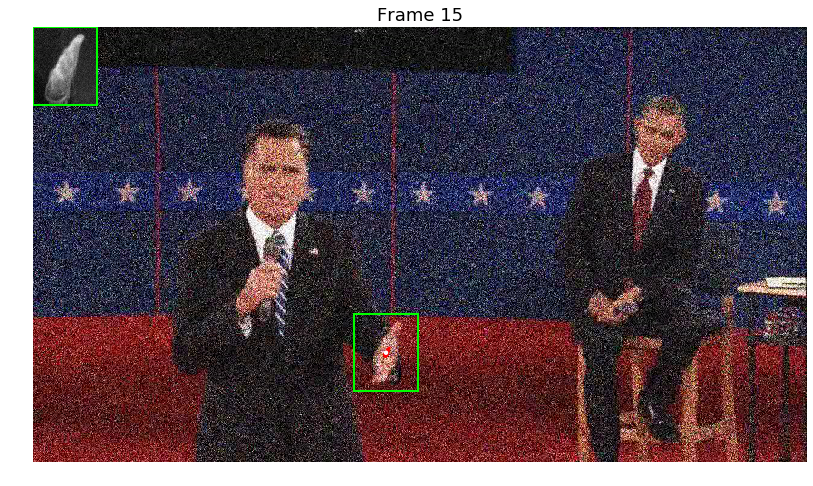

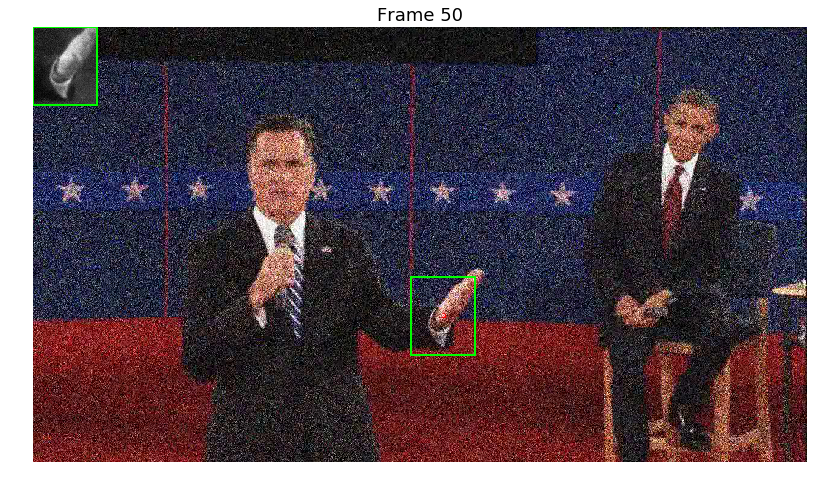

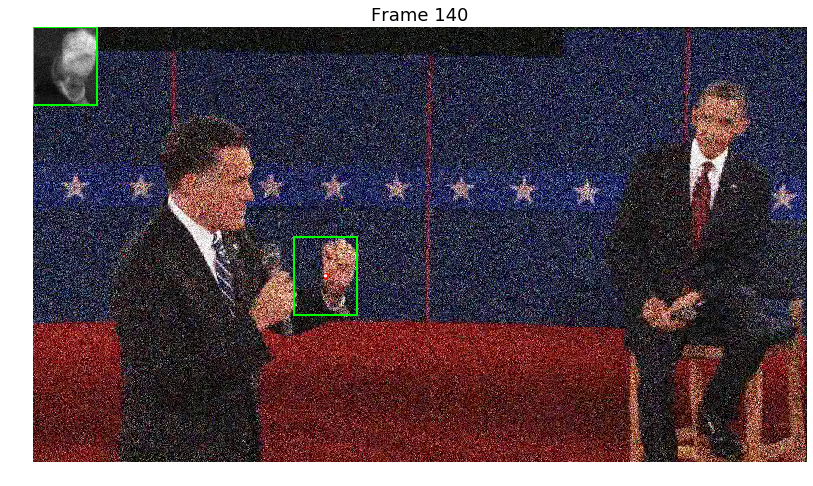

In [291]:
hand_tracker = ParticleFilter(hand, h, w, N=1000, sigma_error=0.01, alpha=0.1)
hand_tracker(noisyvideo, frames=frames, display_video=DISPLAY_VIDEO)

---
## 3. Incorporating More Dynamics

In [7]:
# Template position
with open('pedestrians.txt', 'r') as f:
    x0, y0, w0, h0 = [int(float(n)) for n in f.readline().split()]
# Video file
videofile = 'pedestrians.avi'
# Extract template
firstframe = get_frame(videofile, 1)
h, w = firstframe.shape
woman = firstframe[y0:y0+h0, x0:x0+w0]

### 3.1 Tracking the Woman

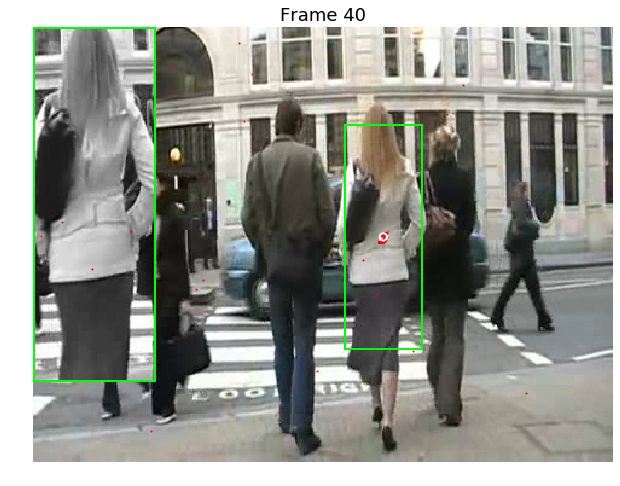

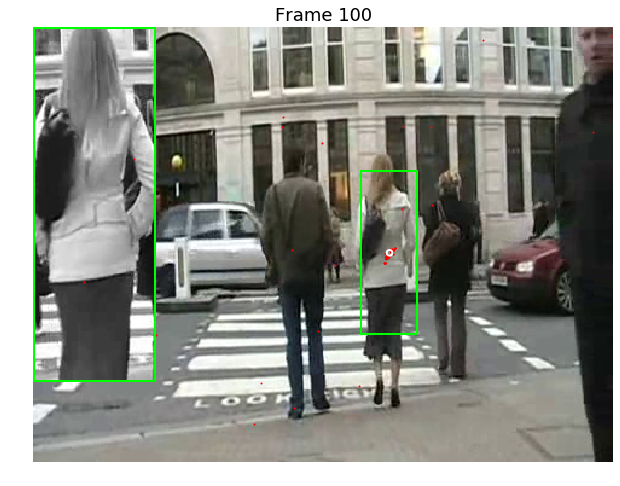

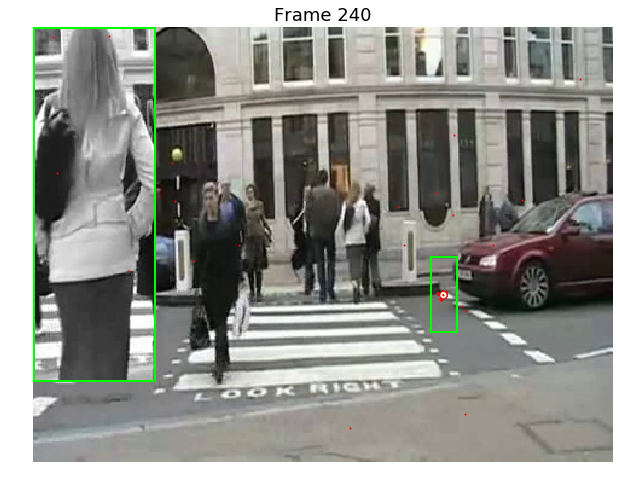

In [8]:
frames = [40, 100, 240]
woman_tracker = ParticleFilter(woman, h, w, include_scale=True, N=1000, sigma_error=0.02, sigma_dynamics=10, sigma_scale=0.1, random_ratio=0.02)
woman_tracker(videofile, frames=frames, display_video=DISPLAY_VIDEO)

### 3.2 Optimizing the number of particles